In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Import csv Data as DataFrame

In [37]:
df = pd.read_csv('data/raw.csv')

In [38]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Problem Statement - Predicting the maths score

In [39]:
# Preparing X and Y variables
x = df.drop(columns=['math score'], axis=1)

In [40]:
x.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [41]:
{col: x[col].unique() for col in x.columns}

{'gender': array(['female', 'male'], dtype=object),
 'race/ethnicity': array(['group B', 'group C', 'group A', 'group D', 'group E'],
       dtype=object),
 'parental level of education': array(["bachelor's degree", 'some college', "master's degree",
        "associate's degree", 'high school', 'some high school'],
       dtype=object),
 'lunch': array(['standard', 'free/reduced'], dtype=object),
 'test preparation course': array(['none', 'completed'], dtype=object),
 'reading score': array([ 72,  90,  95,  57,  78,  83,  43,  64,  60,  54,  52,  81,  53,
         75,  89,  32,  42,  58,  69,  73,  71,  74,  70,  65,  87,  56,
         61,  84,  55,  44,  41,  85,  59,  17,  39,  80,  37,  63,  51,
         49,  26,  68,  45,  47,  86,  34,  79,  66,  67,  91, 100,  76,
         77,  82,  92,  93,  62,  88,  50,  28,  48,  46,  23,  38,  94,
         97,  99,  31,  96,  24,  29,  40], dtype=int64),
 'writing score': array([ 74,  88,  93,  44,  75,  78,  92,  39,  67,  50,  52,  43,  73

In [42]:
y = df['math score']

In [43]:
y.head()

0    72
1    69
2    90
3    47
4    76
Name: math score, dtype: int64

### Converting categorical features into numerical features

In [44]:
# Create column Transformer with 3 types of transformers
num_features = x.select_dtypes(exclude="object").columns
cat_features = x.select_dtypes(include="object").columns


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# ColumnTransformer - Because we have both num. and cat. features -> to apply different transformations to them.


numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [45]:
x = preprocessor.fit_transform(x)

In [46]:
x.shape

(1000, 19)

In [47]:
x

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [48]:
# Seperating the data into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((800, 19), (200, 19))

In [49]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    r2 = r2_score(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    return mae, mse, r2, rmse

In [50]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoost Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
    #"SVR": SVR()
}
model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train) # Train the model

    # Make Prediction
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Evaluate train and test predictions
    model_train_mae, model_train_mse, model_train_r2, model_train_rmse = evaluate_model(y_train, y_train_pred)

    model_test_mae, model_test_mse, model_test_r2, model_test_rmse = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance on train set:')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('-------------------------------------------')

    print('Model performance on test set:')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- Mean Squared Error: {:.4f}".format(model_test_mse))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    # Append the R2 score to the list
    r2_list.append(model_test_r2)
    print('=' * 35)
    print('\n')

Linear Regression
Model performance on train set:
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- Mean Squared Error: 28.3349
- R2 Score: 0.8743
-------------------------------------------
Model performance on test set:
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- Mean Squared Error: 29.0952
- R2 Score: 0.8804


Lasso
Model performance on train set:
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- Mean Squared Error: 43.4784
- R2 Score: 0.8071
-------------------------------------------
Model performance on test set:
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- Mean Squared Error: 42.5064
- R2 Score: 0.8253


Ridge
Model performance on train set:
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- Mean Squared Error: 28.3378
- R2 Score: 0.8743
-------------------------------------------
Model performance on test set:
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- Mean Squared E

### Results

In [51]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model', 'R2 Score']).sort_values(by='R2 Score', ascending=False)

,Model,R2 Score
2,Ridge,0.880593
0,Linear Regression,0.880433
5,Random Forest Regressor,0.852475
7,CatBoost Regressor,0.851632
8,AdaBoost Regressor,0.849446
6,XGBRegressor,0.827797
1,Lasso,0.825320
3,K-Neighbors Regressor,0.783898
4,Decision Tree Regressor,0.729184


## Linear Regression

In [52]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
score = r2_score(y_test, y_pred)*100
print(f"R2 Score/Accuracy: {score:.2f}%")

R2 Score/Accuracy: 88.04%


### Plot y_pred and y_test

Text(0, 0.5, 'Predicted Values')

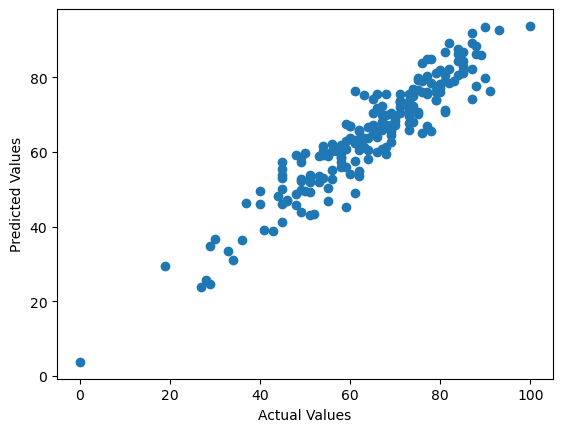

In [53]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

<Axes: xlabel='math score'>

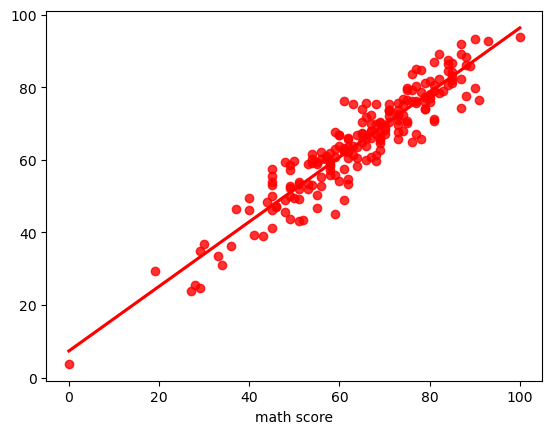

In [54]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='red')

### Difference between Actual and Predicted values

In [55]:
pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_test - y_pred
})
pred_df.head()

,Actual,Predicted,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
